In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from utils.metrics import UnbiasedExponentialMovingAverage as uema
from math import nan
import pytz


In [2]:
data_path = '/home/lolanff/plant-rl/data/online/E7/P2/Constant2/z2/raw.csv'
df = pd.read_csv(data_path)
df['time'] = pd.to_datetime(df['time'])
edmonton_tz = pytz.timezone('America/Edmonton')
df['time'] = df['time'].dt.tz_convert(edmonton_tz)
unique_times = sorted(df['time'].dt.strftime('%H:%M').unique())
print(unique_times)

['09:05', '09:10', '09:20', '09:30', '09:40', '09:50', '10:00', '10:10', '10:20', '10:30', '10:40', '10:50', '11:00', '11:10', '11:20', '11:30', '11:40', '11:50', '12:00', '12:10', '12:20', '12:30', '12:40', '12:50', '13:00', '13:10', '13:20', '13:30', '13:40', '13:50', '14:00', '14:10', '14:20', '14:30', '14:40', '14:50', '15:00', '15:10', '15:20', '15:30', '15:40', '15:50', '16:00', '16:10', '16:20', '16:30', '16:40', '16:50', '17:00', '17:10', '17:20', '17:30', '17:40', '17:50', '18:00', '18:10', '18:20', '18:30', '18:40', '18:50', '19:00', '19:10', '19:20', '19:30', '19:40', '19:50', '20:00', '20:10', '20:20', '20:30', '20:40', '20:50', '21:00']


Text(0.5, 0, 'Time Step')

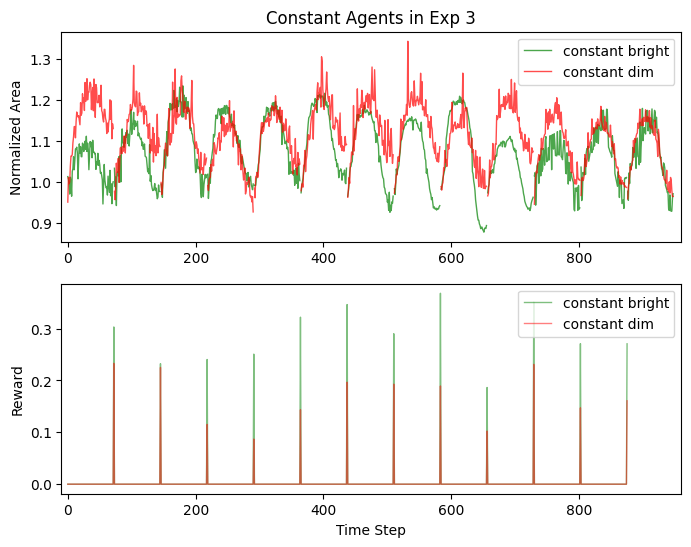

In [31]:
COLORS = ['g', 'r']
AGENTS = ['Constant2/z2', 'Constant1/z1']
NAMES = ['constant bright', 'constant dim']
f, ax = plt.subplots(2, 1, figsize=(8,6))
for i in range(2):
    agent = AGENTS[i]
    data_path = f'/home/lolanff/alien_data/E7/P2/{agent}/raw.csv'
    full_df = pd.read_csv(data_path)
    unique_episodes = sorted(full_df['episode'].unique())
    unique_episodes = unique_episodes[1:14]  # keep the same number of complete episodes across agents
    full_df = full_df[(full_df['episode'] >= min(unique_episodes)) & (full_df['episode'] <= max(unique_episodes))]
    full_areas = full_df['area'].to_numpy()
    full_areas = np.reshape(full_areas, (-1,36))
    full_area = np.array([np.mean(full_areas[i,:]) for i in range(full_areas.shape[0])])

    norm_area = []
    daily_bench = []
    daily_max = []
    for j in unique_episodes:
        df = full_df[full_df['episode'] == j]
        areas = df['area'].to_numpy()
        areas = np.reshape(areas, (-1,36))
        area = np.array([np.mean(areas[i,:]) for i in range(areas.shape[0])])

        # Compute daily measures
        #daily_bench.append(np.mean(np.sort(area[:-1])[-10:])) # daily max area
        daily_max.append(np.mean(np.sort(area[:-1])[-10:])) # daily max area
        daily_bench.append(np.mean(area[:5])) # morning area
        #daily_bench.append(np.mean(area[-5:])) # evening area

        # Normalize area curves
        area = area[:-1] / daily_bench[-1]
        norm_area.append(np.hstack([area, [nan]]))

    ax[0].plot(np.hstack(norm_area), color=COLORS[i], label=NAMES[i], alpha=0.7, linewidth=1)
    ax[0].set_ylabel('Normalized Area')
    ax[0].set_xlim(-10,960)
    ax[0].legend()

    reward = [np.hstack([np.zeros(len(area)), [daily_max[i+1] / daily_max[i] - 1]]) for i in range(len(daily_bench)-1)]
    ax[1].plot(np.hstack(reward), color=COLORS[i], label=NAMES[i], alpha=0.5, linewidth=1)
    #ax[1].set_ylim(0,0.5)
    ax[1].set_ylabel('Reward')
    ax[1].set_xlim(-10,960)
    ax[1].legend()

ax[0].set_title("Constant Agents in Exp 3")
ax[1].set_xlabel('Time Step')

/home/lolanff/ENV/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lolanff/ENV/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17.080286143988808


/home/lolanff/ENV/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lolanff/ENV/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14.113679796376468


/home/lolanff/ENV/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lolanff/ENV/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14.091733983770185


/home/lolanff/ENV/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lolanff/ENV/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


12.59036210729587


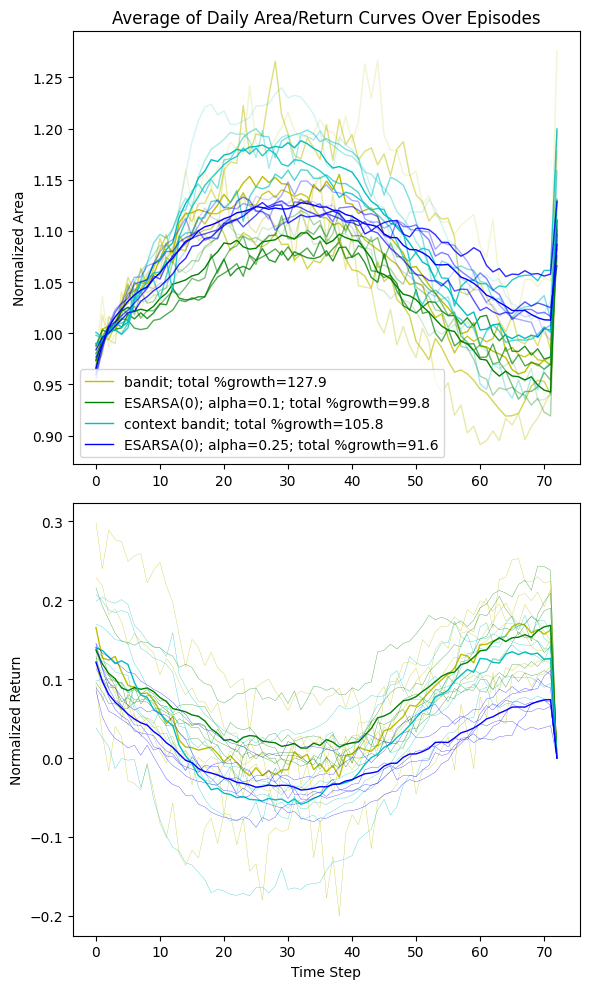

In [4]:
def moving_diff(x, n=10):
    return np.array([np.mean(x[i:i+n]) - np.mean(x[i-n:i]) for i in range(len(x)-n)])

COLORS = ['r', 'y', 'g', 'c', 'b', 'm']
AGENTS = ['P2/Constant2/z2', 'P3/ESARSA3/z3',  'P4/LinearESARSA8/z8', 'P4/LinearESARSA6/z6', 'P4/LinearESARSA9/z9', 'P2/Constant1/z1']
NAMES = ['constant bright', 'bandit',  'ESARSA(0); alpha=0.1', 'context bandit', 'ESARSA(0); alpha=0.25', 'constant dim']

f, ax = plt.subplots(2, 1, figsize=(6,10))
for i in range(1,5):
    agent = AGENTS[i]
    data_path = f'/home/lolanff/alien_data/E7/{agent}/raw.csv'
    full_df = pd.read_csv(data_path)
    unique_episodes = sorted(full_df['episode'].unique())

    # Estimate total % growth
    unique_episodes = unique_episodes[-8:-2]  # keep the same number of complete episodes across agents
    full_df = full_df[(full_df['episode'] >= min(unique_episodes)) & (full_df['episode'] <= max(unique_episodes))]
    full_areas = full_df['area'].to_numpy()
    full_areas = np.reshape(full_areas, (-1,36))
    full_area = np.array([np.mean(full_areas[i,:]) for i in range(full_areas.shape[0])])
    old = np.mean(np.sort(full_area)[:100])   # use the smallest 100 areas to estimate the initial small area
    new = np.mean(np.sort(full_area)[-100:])  # use the largest 100 areas to estimate the final large area
    total_growth = new / old - 1

    A = []
    V = []
    daily_growth = []
    for j in unique_episodes:
        df = full_df[full_df['episode'] == j]
        areas = df['area'].to_numpy()
        areas = np.reshape(areas, (-1,36))
        area = np.array([np.mean(areas[i,:]) for i in range(areas.shape[0])])

        # Estimate daily percentage growth
        daily_growth.append(area[-1] / area[0] - 1)

        # Normalize area curves
        norm = np.mean(area[:5])  # morning area
        #norm = np.mean(np.sort(area[:-1])[-5:])  # daily max area
        area = area / norm
        A.append(area)

        V.append(moving_diff(area[:-1]))

    print(100*np.mean(daily_growth))

    A = np.vstack(A)
    V = np.vstack(V)
    #ax[0].plot(A.T, color=COLORS[i], linewidth=0.2)
    for k in range(A.shape[0]):
        row = A[k,:]
        ax[0].plot(row, alpha=1/A.shape[0]*k, color=COLORS[i], linewidth=1)
    mean_curve = np.mean(A, axis=0)
    ax[0].plot(mean_curve, color=COLORS[i], label=f'{NAMES[i]}; total %growth={100*total_growth:.1f}', linewidth=1)
    ax[0].legend()

    R = np.array([a[-1] - a for a in A])
    ax[1].plot(R.T, color=COLORS[i], linewidth=0.2)
    ax[1].plot(np.mean(R, axis=0), color=COLORS[i], linewidth=1)

ax[0].set_ylabel('Normalized Area')
ax[1].set_ylabel('Normalized Return')
ax[0].set_title("Average of Daily Area/Return Curves Over Episodes")
ax[1].set_xlabel('Time Step')
f.tight_layout()

Text(0.5, 1.0, 'Mean=-0.810, 0.081, 0.332')

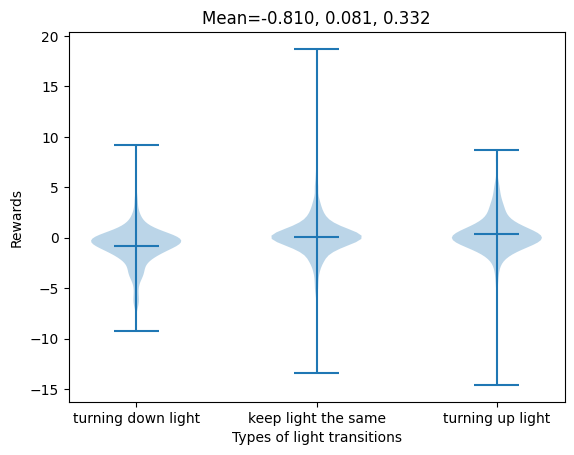

In [5]:
AGENTS = ['P4/LinearESARSA6/z6', 'P4/LinearESARSA8/z8', 'P4/LinearESARSA9/z9', 'P3/ESARSA3/z3']
down_reward = []
up_reward = []
flat_reward = []
f, ax = plt.subplots()
for i in range(4):
    agent = AGENTS[i]
    data_path = f'/home/lolanff/alien_data/E7/{agent}/raw.csv'
    full_df = pd.read_csv(data_path)
    unique_episodes = sorted(full_df['episode'].unique())

    for j in unique_episodes[1:-1]:
        df = full_df[full_df['episode'] == j]
        areas = df['area'].to_numpy()
        areas = np.reshape(areas, (-1,36))
        area = np.array([np.mean(areas[i,:]) for i in range(areas.shape[0])])
        area = area[:-1]   # remove overnight reward

        actions = df['agent_action'].to_numpy()
        actions = np.reshape(actions, (-1,36))
        action = actions[:, 0]

        down_idx = np.argwhere(np.diff(action) == -1).T
        up_idx = np.argwhere(np.diff(action) == 1).T
        flat_idx = np.argwhere(np.diff(action) == 0).T

        down_reward.append(area[down_idx + 1] - area[down_idx])
        up_reward.append(area[up_idx + 1] - area[up_idx])
        flat_reward.append(area[flat_idx + 1] - area[flat_idx])

down_reward = np.hstack(down_reward)[0]
up_reward = np.hstack(up_reward)[0]
flat_reward = np.hstack(flat_reward)[0]

ax.violinplot([down_reward, flat_reward, up_reward], showmeans=True)

ax.set_xticks([1, 2, 3], labels=['turning down light', 'keep light the same', 'turning up light'])
ax.set_xlabel('Types of light transitions')
ax.set_ylabel('Rewards')
ax.set_title(f'Mean={np.mean(down_reward):.3f}, {np.mean(flat_reward):.3f}, {np.mean(up_reward):.3f}')

In [6]:
area = np.array([np.mean(areas[i,:]) for i in range(areas.shape[0])])
#area =  np.array([np.mean(areas[,i]) for i in range(areas.shape[1])])

In [7]:
area_trace = uema(alpha=0.01)
area_trace.update(area[0])
smooth_area = [area_trace.compute().item()]
r1 = np.hstack([[0], np.diff(area)])
r2 = []
r3 = []
m = 18
for i in range(1, len(area)):
    area_trace.update(area[i])
    smooth_area.append(area_trace.compute().item())

    if i % m == 0 and i >= 2*m:
        r2.append(np.mean(area[i-m:i]) - np.mean(area[i-m*2:i-m]))
        r3.append(smooth_area[-1] - smooth_area[-1-m])
    else:
        r2.append(0)
        r3.append(0)

r2 = np.array(r2)
r3 = np.array(r3)

def R(x):
    return np.flip(np.cumsum(np.flip(x)))

Text(0.5, 0, 'Daytime Time Step')

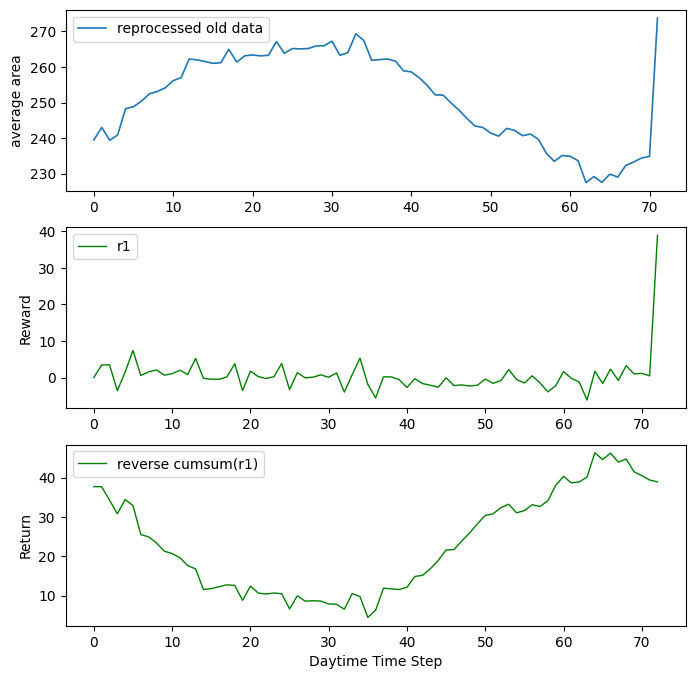

In [8]:
fig, ax = plt.subplots(3,1, figsize=(8,8))
ax[0].plot(area[1:], linewidth=1.2, label='reprocessed old data')
ax[0].legend()
ax[0].set_ylabel('average area')
ax[1].plot(r1, 'g', linewidth=1, alpha=1, label='r1')
#ax[1].plot(r2, 'r', linewidth=1,alpha=0.7, label='r2')
ax[1].legend()
ax[1].set_ylabel('Reward')
#ax[1].set_ylim(-20,20)
ax[2].plot(R(r1), 'g', linewidth=1, alpha=1,label='reverse cumsum(r1)')
#ax[2].plot(R(r2), 'r', linewidth=1, alpha=0.7,label='reverse cumsum(r2)')
ax[2].legend()
ax[2].set_ylabel('Return')
ax[2].set_xlabel('Daytime Time Step')